# Pocillo detection and data extraction

In [17]:
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

## 1. Pocillos detection
* We use a 'circle detection' function to find out the exact location of each pocillo.

In [18]:
#img_path = 'pics/Picture_g_10M5_#1_2023-04-19_14:08:37_P4_Cam3.jpg'
img_path = 'pics/Picture_g_10M5_#1_2023-04-19_14:06:53_P3_Cam4.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [19]:
# Circle detection
circles = cv2.HoughCircles(img_bw, cv2.HOUGH_GRADIENT,1,100, param1=50,param2=30,minRadius=80,maxRadius=90)
circles = circles.astype(int)[0,:,:]

if circles is not None:
    for pt in circles:
        a, b, r = pt[0], pt[1], pt[2]
        cv2.circle(img, (a, b), r, (255, 255, 255), 20)
        cv2.circle(img, (a, b), 1, (0, 0, 255), 3)

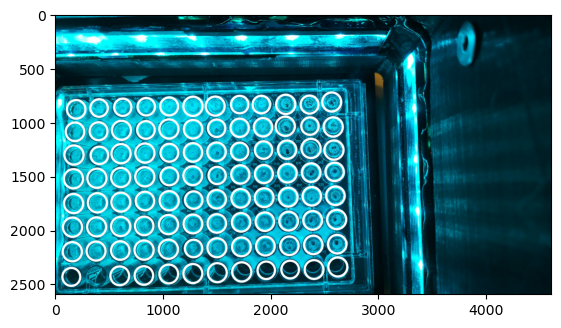

In [20]:
plt.imshow(img)
plt.show()

### Pocillos location

In [21]:
# Location algorithm for desired pocillo
x_kmeans = KMeans(n_clusters=12, n_init=10).fit(circles[:,0].reshape(-1, 1))
x_labels = x_kmeans.labels_
x_centers = x_kmeans.cluster_centers_.squeeze()
x_new_labels = np.zeros_like(x_labels)
for i in range(len(x_centers)):
    x_new_labels[x_labels == i] = np.where(np.argsort(x_centers) == i)[0][0] 

y_kmeans = KMeans(n_clusters=8, n_init=10).fit(circles[:,1].reshape(-1, 1))
y_labels = y_kmeans.labels_
y_centers = y_kmeans.cluster_centers_.squeeze()
y_new_labels = np.zeros_like(y_labels)
for i in range(len(y_centers)):
    y_new_labels[y_labels == i] = np.where(np.argsort(y_centers) == i)[0][0] 

In [22]:
import pandas as pd
circles_df = pd.DataFrame(np.column_stack((circles, y_new_labels,x_new_labels)))
circles_df.columns = ["x_center", "y_center", "radius", "row_num", "col_num"]

In [23]:
# IMPORTANT! Function updating 'circles' to the real 96 it should be
# If something goes wrong, hard-code the position of the 96 circles (& warn, I guess)

In [24]:
def locate_pocillo(position):
# Get center and radius of pocillo
    index_array = np.where((x_new_labels+1 == position[1]) & (y_new_labels+1 == position[0]))[0]
    
    if index_array.size ==0:
        print("Hough Transform didn't locate this one!")
    else:
        index = index_array[0]
        center = circles[index][:-1]
        radius = circles[index][-1]
        # Plot
        img_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        my_point = cv2.circle(img_bw, center, radius, (255, 0, 0), -1)
        plt.imshow(my_point)
        plt.show()

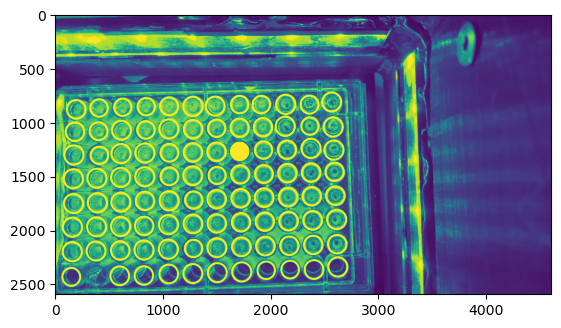

In [25]:
locate_pocillo((3,8))

## 2. Data extraction
* In this case, we want to extract the **mean value of the green channel** among the pixels of each pocillo.

In [26]:
def circle_crop(input_img, circle):
    center, radius = circle[0:2], circle[2]
    cropped_pocillo = input_img[center[1] - radius: center[1] + radius, center[0] - radius: center[0] + radius, :]
    width, height = cropped_pocillo.shape[0:2]
    final_img = cropped_pocillo
    for x in range(width):
        for y in range(height):
            dist = (x-width//2)**2 + (y-height//2)**2 
            if dist > radius**2:
                final_img[y,x,0], final_img[y,x,1], final_img[y,x,2] = 0,0,0 
    return final_img

In [27]:
def non_zero_average(arr):
    non_zero_arr = arr[arr != 0]
    return round(np.mean(non_zero_arr),2)

In [28]:
output_array = np.zeros((8,12))
positions = np.column_stack((y_new_labels,x_new_labels))

In [29]:
for i, position in enumerate(positions):
    cropped_pocillo = circle_crop(img, circles[i,:])
    cropped_pocillo_green = cropped_pocillo[:,:,1]
    output_array[position[0], position[1]] = non_zero_average(cropped_pocillo_green)

In [30]:
import pandas as pd
column_names = ['1','2','3','4','5','6','7','8','9','10','11','12']
row_names = ['A','B','C','D','E','F','G','H']
pd.DataFrame(output_array, columns = column_names, index = row_names)

,1,2,3,4,5,6,7,8,9,10,11,12
A,190.52,205.54,209.76,211.72,221.87,216.36,209.08,204.54,207.87,187.86,186.22,177.58
B,191.68,209.05,207.19,213.49,209.96,215.67,203.98,206.76,206.00,175.18,186.54,183.77
C,186.95,204.99,206.52,208.18,210.56,208.86,202.45,200.06,193.92,177.51,173.80,177.08
D,185.34,203.53,206.84,204.74,205.22,200.29,191.86,190.28,191.50,198.67,176.75,177.81
E,186.95,200.45,205.95,201.25,199.25,191.11,190.43,193.94,190.79,197.92,192.07,176.88
F,182.15,197.69,199.82,195.68,191.78,190.01,190.33,185.75,186.64,173.08,173.66,177.99
G,175.56,187.52,193.40,187.57,183.83,177.69,183.63,180.71,178.21,167.16,168.07,170.07
H,103.51,0.00,135.06,131.37,121.98,114.93,120.55,104.87,100.25,98.03,99.40,95.41


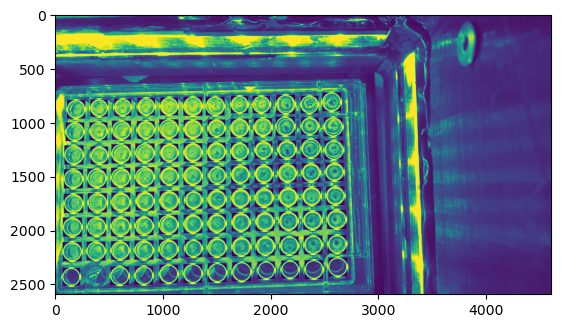

In [68]:
plt.imshow(img[:,:,1])
plt.show()